In [1]:
# Extracao de dados de patentes
# url - www.freepatentsonline.com
#
# Henrique Cursino Vieira
# versao 0.1 

In [1]:
# dataframe
import re
import pandas as pd

# webscraping
import requests
from bs4 import BeautifulSoup

# nuvem de palavras
from wordcloud import WordCloud

In [2]:
# cada pagina lista 50 patentes, alterar a variavel n para obter o numero de
# patentes de interesse
p = 4

In [8]:
# Nome das colunas
columns = ["Match", "Document", "Document_Title", "Score"]

In [8]:
rows = []
for pagina in range(1,p+1):
    pagina = str(pagina)
    link = "https://www.freepatentsonline.com/result.html?p={}&sort=relevance&srch=top&query_txt=agronomy&patents_us=on".format(pagina)
    
    page = requests.get(link)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Capturando o conteudo da tag <td> e pulando as duas primeiras tags
    listing_table = soup.findAll("td")[2:202]    
    
    for i in range(0, len(listing_table), 4):

    #     print(i)
        match, document, document_title, score = listing_table[i:i+4]
        rows.append([match, document, document_title, score])  

In [10]:
print('Total de linhas:', len(rows))

Total de linhas: 200


In [11]:
# Verificando o conteudo
listing_table[2]

<td valign="top" width="60%">
<a href="/5969222.html">Corn inbred lines for dairy cattle feed</a>
         
                            <br/>
                An inbred corn line designated AR5153bm3 is disclosed. AR5153bm3 is useful for producing F1 hybrid corn seed and plants therefrom. Such corn plants exhibit the brown midrib phenotype and yield a...    </td>

In [12]:
# lista de links
urls = []
for i in range(len(listing_table)):

    td = listing_table[i]
    a = td.findAll('a')
    
    if a:
        urls.append("https://www.freepatentsonline.com"+a[0].get('href'))

In [13]:
# extraindo os dados dos documentos de patentes
tmp = dict()

for i, url in enumerate(urls):
    
    tmp[i] = []
    url_splited = url.split('/')
    
    if len(url_splited) == 4:
        idx = url_splited[3].replace('.html', '')
        
    if len(url_splited) == 5:
        idx = url_splited[4].replace('.html', '')

    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    tmp[i].append(['idx', idx])
    
    for row in soup.findAll("div", {"class":"disp_doc2"}):
        
        title_content = row.findAll("div", {"class":"disp_elm_title"})
        text_content = row.findAll("div", {"class":"disp_elm_text"})
        title = None
        text = None
        
        if title_content:
            title = title_content[0].text

            if text_content:
                text = text_content[0].text

            tmp[i].append([title, text])

In [14]:
# Verificando o conteudo de text
tmp[0][2][1]

'\n            An inbred corn line designated AR5153bm3 is disclosed. AR5153bm3 is useful for producing F1 hybrid corn seed and plants therefrom. Such corn plants exhibit the brown midrib phenotype and yield a silage that, when fed to dairy cattle, increases milk production.        '

In [15]:
rows = []
for i in range(len(tmp)):
    
    row = [tmp[i][0][1], tmp[i][1][1], tmp[i][2][1]]
    rows.append(row)

In [16]:
data = pd.DataFrame(rows, columns = ['idx', 'title_raw', 'text_raw'])
data.head(10)

,idx,title_raw,text_raw
0,5969222,\n\n Corn inbred lines for ...,\n An inbred corn line designated A...
1,6114609,\n\n Corn inbred lines for ...,\n An inbred corn line designated A...
2,5859353,\n\n Corn Inbred lines for ...,\n An inbred corn line designated A...
3,5714670,\n\n Soybeans having low li...,\n A novel soybean seed and plant d...
4,5763745,\n\n Soybeans having low li...,\n Methods are described for the pr...
5,10319050,\n\n Systems for adjusting ...,"\n Methods, systems, and apparatus,..."
6,10477756,\n\n Correcting agronomic d...,\n Inaccurate agronomic data may be...
7,7169982,\n\n Starch \n,\n This invention relates to a meth...
8,5332673,\n\n Application of native ...,\n Novel modified and unmodified so...
9,6147193,\n\n Soybean products with ...,\n There is provided soybean protei...


In [17]:
def preprocess_text(text = None):
    
    processed_text = re.sub('\n{1,}', '', text).strip().lower()    
    return processed_text

In [18]:
# pre processamento dos dados e gerando uma coluna unificando titulo e texto
data['title']   = data['title_raw'].apply(lambda x : preprocess_text(x))
data['text']    = data['text_raw'].apply(lambda x : preprocess_text(x))
data['content'] = data['title'] + " " + data['text']
data.head(10)

,idx,title_raw,text_raw,title,text,content
0,5969222,\n\n Corn inbred lines for ...,\n An inbred corn line designated A...,corn inbred lines for dairy cattle feed,an inbred corn line designated ar5153bm3 is di...,corn inbred lines for dairy cattle feed an inb...
1,6114609,\n\n Corn inbred lines for ...,\n An inbred corn line designated A...,corn inbred lines for dairy cattle feed,an inbred corn line designated ar5253bm3 is di...,corn inbred lines for dairy cattle feed an inb...
2,5859353,\n\n Corn Inbred lines for ...,\n An inbred corn line designated A...,corn inbred lines for dairy cattle feed,an inbred corn line designated ar5252bm3 is di...,corn inbred lines for dairy cattle feed an inb...
3,5714670,\n\n Soybeans having low li...,\n A novel soybean seed and plant d...,soybeans having low linolenic acid and low pal...,a novel soybean seed and plant designated ax77...,soybeans having low linolenic acid and low pal...
4,5763745,\n\n Soybeans having low li...,\n Methods are described for the pr...,soybeans having low linolenic acid content and...,methods are described for the production of so...,soybeans having low linolenic acid content and...
5,10319050,\n\n Systems for adjusting ...,"\n Methods, systems, and apparatus,...",systems for adjusting agronomic inputs using r...,"methods, systems, and apparatus, including com...",systems for adjusting agronomic inputs using r...
6,10477756,\n\n Correcting agronomic d...,\n Inaccurate agronomic data may be...,correcting agronomic data from multiple passes...,inaccurate agronomic data may be identified an...,correcting agronomic data from multiple passes...
7,7169982,\n\n Starch \n,\n This invention relates to a meth...,starch,this invention relates to a method of producin...,starch this invention relates to a method of p...
8,5332673,\n\n Application of native ...,\n Novel modified and unmodified so...,application of native soil bacteria as selecti...,novel modified and unmodified soil and rhizo-p...,application of native soil bacteria as selecti...
9,6147193,\n\n Soybean products with ...,\n There is provided soybean protei...,soybean products with improved carbohydrate co...,there is provided soybean protein products of ...,soybean products with improved carbohydrate co...


In [19]:
data['content'].tolist()[10]

'stabilized enhanced efficiency controllable release calcium cyanamide compositions calcium cyanamide compositions and methods for their use are disclosed. the compositions and methods stabilize active ionic compositions comprising calcium cyanamide and enhance the effectiveness of calcium cyanamide alone or synergistically in combination with nitrogen containing materials such as urea and organics, for example, manures. the compositions and methods also facilitate controllable site directed delivery of the contents of the stabilized compositions. the compositions and methods are effective for fertilizing, soil amending, metal stabilizing and odor and organism inhibition. the compositions are stable, easily calibrated, and non-clogging for spray delivery to target sites.'

In [26]:
# nuvem de palavras
text = ', '.join(list(data['content'].values))
wordcloud = WordCloud(background_color="white", 
                      max_words=5000, 
                      contour_width=3, 
                      contour_color='steelblue',
                      width=1200, 
                      height=800,
                      collocations=False)

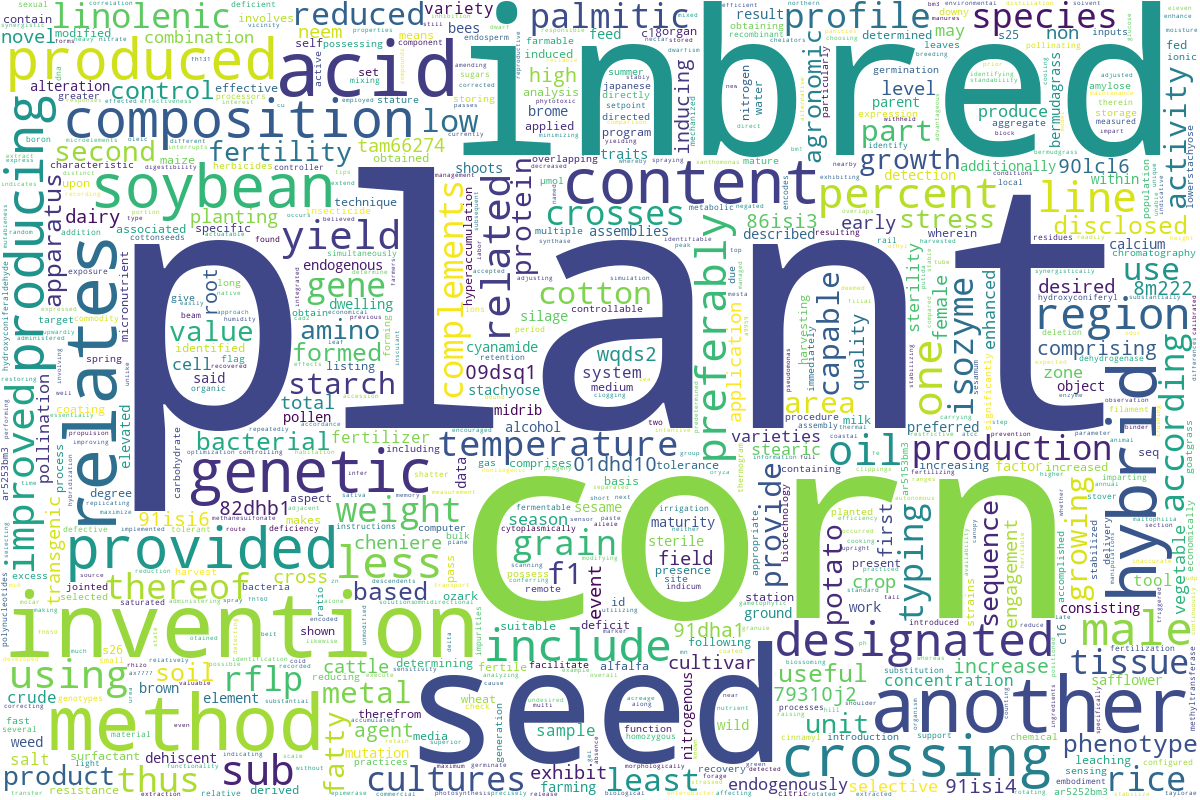

In [27]:
wordcloud.generate(text)
wordcloud.to_image()

In [28]:
wordcloud.to_file(filename='wordcloud_preprocess.png')

In [24]:
data.to_csv('patents_data.csv', index = False)